<a href="https://colab.research.google.com/github/isaac1987a/Something_of_a_Painter_Myself/blob/main/Copy_of_Monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists("/root/.kaggle/"):
    os.makedirs("/root/.kaggle/")
    with open("/root/.kaggle/kaggle.json", "w+") as f:
      # Write the text to the file
      f.write("""{"username":"isaacblach","key":
        "599d02c69c483f5ead7487a5b0bbae5b"}""")
!chmod 600 /root/.kaggle/kaggle.json
!pip install tensorflow-addons pandas matplotlib kaggle


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


# Project Goal and Overview
The goal of this project is to create a Generative Adversarial Network (GAN) to convert images into the monet style.  To do this, I will use the 300 monet images to perform the training.  There are 300 Monets

In [2]:
import kaggle
import zipfile
import keras
from keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import random
import math
import tensorflow_addons as tfa
autotune = tf.data.AUTOTUNE
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2024-05-29 00:29:03.160734: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 00:29:03.191795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 00:29:03.191824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 00:29:03.192824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 00:29:03.197954: I tensorflow/core/platform/cpu_feature_guar

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


In [3]:
if not os.path.exists('kaggle'):
    !kaggle competitions download -c 'gan-getting-started'
    #!mkdir kaggle
    #!mkdir kaggle/input
    #!mkdir kaggle/input/gan-getting-started
    #!unzip -qq gan-getting-started.zip -d kaggle/input/gan-getting-started
    with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
        zip_ref.extractall('./kaggle/input/gan-getting-started')

# Data Description


In [4]:
def count_files_in_directory(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(
        os.path.join(directory_path, f))]
    # Count the number of files
    file_count = len(files)
    return file_count
directory_path = './kaggle/input/gan-getting-started/monet_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Monet Images.')

directory_path = './kaggle/input/gan-getting-started/photo_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Monet Images.')

There are 300 Monet Images.
There are 7038 Monet Images.


20 Monet Images above 20 Photos


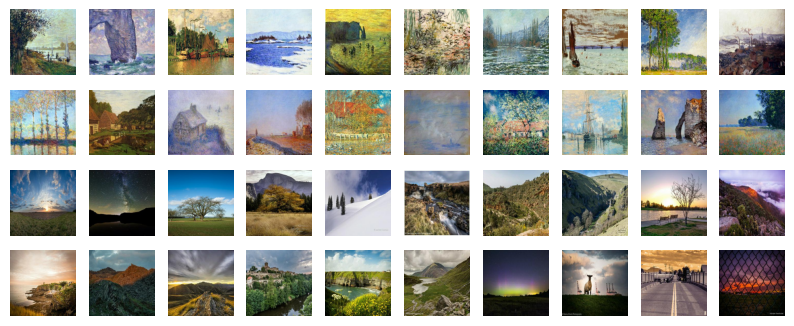

In [5]:
#Generated by Gemini AI but modified to actually work
# Get a list of all the files in the Monet directory
monet_files = os.listdir("./kaggle/input/gan-getting-started/monet_jpg")

# Get a list of all the files in the photo directory
photo_files = os.listdir("./kaggle/input/gan-getting-started/photo_jpg")

# Select 20 random Monet images
random_monet_files = random.sample(monet_files, 20)

# Select 20 random photo images
random_photo_files = random.sample(photo_files, 20)

# Create a 10x2 grid of subplots
fig, axes = plt.subplots(4, 10, figsize=(10, 4))
print("20 Monet Images above 20 Photos")

# Plot the Monet images in the first column

for i, filename in enumerate(random_monet_files):
    img = mpimg.imread(os.path.join("./kaggle/input/gan-getting-started/monet_jpg", filename))
    axes[math.floor(i%2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2), math.floor(i/2)].axis('off')

## Plot the photo images in the second column
for i, filename in enumerate(random_photo_files):
    img = mpimg.imread(os.path.join("./kaggle/input/gan-getting-started/photo_jpg", filename))
    axes[math.floor(i%2+2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2+2), math.floor(i/2)].axis('off')

# Show the plot
plt.show()


# Data Loading and Batch Sizes
In order to perform faster data loading, I chose to load the tfrec files.  I then selected a batch size of 30 as that evenly breaks up the dataset into 10 batches.  This will allow for paralell processing across 8 TPU units.

In [6]:
def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [256, 256])
  return image

def read_tfrecord(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string),
  }
  example = tf.io.parse_single_example(example, features)
  image = decode_image(example['image'])
  return image
tfrecord_dir = './kaggle/input/gan-getting-started/monet_tfrec'
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
monet_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)

tfrecord_dir = './kaggle/input/gan-getting-started/photo_tfrec'
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
photo_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)
print(monet_images_dataset)


<_MapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>


2024-05-29 00:29:07.788388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2024-05-29 00:29:07.789352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22283 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:21:00.0, compute capability: 8.9
2024-05-29 00:29:07.790870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22283 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9
2024-05-29 00:29:07.791551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22283 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 4090

In [7]:
# prompt: split TFRecordDataset into a train and test set 80/20 split

monet_dataset_size = tf.data.experimental.cardinality(
    monet_images_dataset).numpy()
train_size = int(0.8 * monet_dataset_size)

monet_train_dataset = monet_images_dataset.take(train_size)
monet_test_dataset = monet_images_dataset.skip(train_size)

photo_dataset_size = tf.data.experimental.cardinality(
    monet_images_dataset).numpy()
train_size = int(0.8 * photo_dataset_size)

photo_train_dataset = photo_images_dataset.take(train_size)
photo_test_dataset = photo_images_dataset.skip(train_size)

TPU Setup copied from https://www.tensorflow.org/guide/tpu

#  Starting off the GAN
I used https://keras.io/examples/generative/cyclegan/ as a reference for the initial model build.

In [8]:
img_size = 256
image_depth = 3
batch_size = 4
LR = 0.00012
buffer_size = 256

In [9]:
# https://keras.io/examples/generative/cyclegan/
# Define the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Random flip
    print(img)
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [10]:
# Apply the preprocessing operations to the training data

monet_test_dataset = (
    monet_test_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
monet_train_dataset = (
    monet_train_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Apply the preprocessing operations to the test data
photo_train_dataset = (
    photo_train_dataset.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
photo_test_dataset = (
    photo_test_dataset.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


Tensor("args_0:0", shape=(256, 256, 3), dtype=float32)
Tensor("args_0:0", shape=(256, 256, 3), dtype=float32)


In [11]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [12]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [13]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [14]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM)
        self.identity_loss_fn = keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM)

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [15]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_horses.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.utils.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()


In [17]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return tf.reduce_mean(fake_loss)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

# Assuming you have already defined your strategy
strategy = tf.distribute.MirroredStrategy()
print(strategy)
with strategy.scope():
    # Create cycle gan model
    cycle_gan_model = CycleGan(
        generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
    )

    # Compile the model
    cycle_gan_model.compile(
        gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_loss_fn=generator_loss_fn,
        disc_loss_fn=discriminator_loss_fn
    )

    # Callbacks for checkpointing
    checkpoint = tf.train.Checkpoint(cycle_gan_model=cycle_gan_model)
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory='./checkpoints', max_to_keep=5)

    # Train the model manually and save checkpoints
    EPOCHS = 10  # Number of epochs you want to train
    cycle_gan_model.fit(
        tf.data.Dataset.zip((photo_train_dataset, photo_test_dataset)),
        epochs=1,
        callbacks=[plotter, model_checkpoint_callback],
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, grou

ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_4710/891300481.py", line 116, in train_step
        self.gen_G_optimizer.apply_gradients(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 638, in apply_gradients
        self.build(trainable_variables)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/adam.py", line 145, in build
        self.add_variable_from_reference(
    File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 1124, in add_variable_from_reference
        with strategy.extended.colocate_vars_with(model_variable):

    ValueError: `colocate_vars_with` must only be passed a variable created in this tf.distribute.Strategy.scope(), not: <tf.Variable 'conv2d/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
    array([[[[ 2.29498390e-02, -1.33009152e-02, -1.17771253e-02, ...,
              -2.63523906e-02, -1.64484065e-02,  1.38045065e-02],
             [ 1.05066178e-03, -5.49857412e-03,  3.15914564e-02, ...,
              -2.89538279e-02, -7.15859002e-03,  1.08227497e-02],
             [-4.92029684e-03, -1.46494163e-02,  2.15112381e-02, ...,
              -4.48846770e-03,  3.70321535e-02, -8.34391080e-03]],
    
            [[ 1.20478095e-02, -1.13338195e-02,  2.34283810e-03, ...,
              -3.71563807e-02,  2.74242630e-04,  3.07464264e-02],
             [ 6.19716151e-03,  8.39404296e-03,  4.03223522e-02, ...,
               1.41263066e-03,  2.01342464e-03, -3.69532127e-03],
             [-7.35420221e-03,  1.27647929e-02,  2.03109812e-02, ...,
               9.96975508e-03, -1.64165795e-02, -1.09103303e-02]],
    
            [[-1.85077614e-03,  1.23556238e-02,  1.73861571e-02, ...,
               2.20941589e-03,  1.20187318e-02, -2.43173484e-02],
             [-5.45065477e-02,  2.18577147e-03,  4.88097966e-03, ...,
              -2.19889283e-02,  1.99822132e-02, -3.59195061e-02],
             [ 1.96729414e-02,  3.85542703e-03,  3.31561640e-02, ...,
               2.37075724e-02,  3.05698365e-02, -4.15328741e-02]],
    
            ...,
    
            [[ 9.67983156e-03, -3.22629996e-02, -8.36592074e-03, ...,
               4.48662527e-02, -5.70057379e-03, -1.33265071e-02],
             [-1.79192480e-02, -1.34856915e-02,  1.21023357e-02, ...,
               2.83224247e-02,  1.76887177e-02,  1.93452695e-03],
             [ 2.81066634e-02, -1.31082104e-03, -5.10311732e-03, ...,
              -2.06826273e-02, -2.49668444e-03, -3.80394012e-02]],
    
            [[-9.53405909e-03, -1.68988425e-02, -1.58308819e-02, ...,
               2.30191778e-02, -1.62572581e-02,  1.41921686e-03],
             [ 4.48837131e-03,  1.18444702e-02,  4.15008478e-02, ...,
              -4.57654474e-03,  7.98805431e-03,  4.53801267e-03],
             [ 6.40445389e-03, -1.64366532e-02,  1.78123377e-02, ...,
              -2.39564627e-02,  1.33249015e-02, -3.46180871e-02]],
    
            [[-4.89825867e-02, -1.35752643e-02,  1.00311255e-02, ...,
              -1.10516855e-02,  1.86969452e-02,  2.87149828e-02],
             [ 9.19281412e-03,  9.58555937e-03, -1.40127419e-02, ...,
              -2.87497658e-02, -9.12553165e-03,  4.88976366e-04],
             [ 1.69255608e-03,  3.73146788e-04,  1.69053618e-02, ...,
               1.59454737e-02, -3.53070982e-02,  4.52073477e-03]]],
    
    
           [[[ 2.18931539e-03,  3.90237849e-03, -2.96203420e-03, ...,
              -2.53081098e-02,  2.74916142e-02,  1.90150626e-02],
             [-2.22362019e-03,  1.76767521e-02, -9.50794015e-03, ...,
               1.66757195e-03, -3.22005060e-03,  1.93520691e-02],
             [ 3.90892895e-03, -1.36436317e-02,  4.60038520e-02, ...,
              -2.48203874e-02, -2.31902990e-02,  1.77669432e-02]],
    
            [[ 2.11926270e-02, -2.51142681e-02, -6.71087718e-03, ...,
              -4.63384250e-03, -1.08421706e-02,  9.74866748e-03],
             [ 4.24877554e-03,  1.18717011e-02,  1.37868505e-02, ...,
              -3.45677361e-02, -3.29359807e-02, -7.86800869e-03],
             [ 1.73799563e-02,  7.90102594e-03, -3.84156257e-02, ...,
              -8.03195871e-03,  2.88493652e-02,  4.45408514e-03]],
    
            [[ 3.62175168e-03,  3.23928520e-02,  1.66173689e-02, ...,
              -1.70265213e-02,  7.47934263e-03,  2.78608804e-03],
             [-8.44711729e-04,  1.45127652e-02, -1.12561136e-02, ...,
              -1.25372205e-02, -1.49328504e-02, -2.02913247e-02],
             [ 3.09225870e-03,  1.68888271e-02,  6.13049185e-03, ...,
              -1.47349732e-02, -3.31810042e-02,  1.47172231e-02]],
    
            ...,
    
            [[-1.21607529e-02, -1.28654493e-02, -2.25164201e-02, ...,
               2.56979130e-02,  1.44939357e-02,  1.86187611e-03],
             [ 4.02201572e-03,  1.90810934e-02,  1.77970603e-02, ...,
              -6.17234642e-03, -5.54867904e-04,  1.84764713e-03],
             [ 2.57126726e-02, -2.45366227e-02, -2.53130402e-02, ...,
               9.03900340e-03,  3.02811880e-02, -3.44203189e-02]],
    
            [[-2.30951118e-03, -2.63080820e-02,  2.91800946e-02, ...,
              -2.59794984e-02,  5.45499788e-04,  2.24870793e-03],
             [ 1.89976804e-02, -3.17917094e-02,  1.00836623e-02, ...,
              -1.17018418e-02,  1.72522999e-02, -1.11047011e-02],
             [ 2.71334220e-02,  1.51429642e-02, -4.50221502e-04, ...,
               1.65222830e-03, -1.77232083e-02, -1.50516583e-02]],
    
            [[ 4.76564020e-02, -3.48857697e-03,  1.14311082e-02, ...,
               8.90991744e-03, -2.04447601e-02,  2.71991896e-03],
             [-2.46475339e-02,  3.14747095e-02,  2.40742937e-02, ...,
              -5.04485518e-03, -1.79140922e-02, -3.92019562e-02],
             [-6.43755915e-03,  2.18151174e-02,  4.56438679e-03, ...,
              -1.04858885e-02,  2.28369944e-02, -1.65083390e-02]]],
    
    
           [[[ 7.51921581e-03, -2.69259289e-02, -3.72333787e-02, ...,
              -1.04434546e-02, -3.28896381e-02, -2.25766911e-03],
             [ 2.06404738e-02,  3.48777995e-02, -1.57331266e-02, ...,
               2.27999035e-02, -2.80479956e-02,  1.25557333e-02],
             [ 3.74927968e-02,  8.97919573e-03, -1.93808917e-02, ...,
              -1.30389556e-02, -2.73684468e-02, -1.52944336e-02]],
    
            [[ 2.93989703e-02,  1.33045893e-02, -1.07567878e-02, ...,
               1.50138671e-02,  1.61097515e-02, -2.10439172e-02],
             [-1.57041252e-02,  1.20517612e-02,  1.38095170e-02, ...,
               9.03748628e-03, -1.83568466e-02,  2.74197422e-02],
             [-4.90480242e-03,  5.92154125e-03, -1.30478311e-02, ...,
               2.64160912e-02,  3.09956856e-02,  3.10402941e-02]],
    
            [[ 6.84396597e-03, -1.46080935e-02, -2.63528023e-02, ...,
              -3.90447788e-02,  9.04908124e-03, -1.22741517e-02],
             [-5.83878942e-02, -4.08570888e-03, -1.87799742e-03, ...,
               1.72303803e-02,  5.88485226e-03,  6.65961253e-03],
             [ 1.75989754e-02,  4.86824894e-03,  2.69801710e-02, ...,
              -8.22343491e-03, -1.59062948e-02, -1.65482052e-02]],
    
            ...,
    
            [[ 1.00240612e-03, -1.01448852e-03,  1.92091372e-02, ...,
               2.07810309e-02, -2.08545104e-03,  4.94427572e-04],
             [-6.14849385e-03, -4.38525751e-02, -2.16239635e-02, ...,
              -2.14254465e-02, -5.53694852e-02,  2.60442421e-02],
             [-1.36528819e-04, -2.16118563e-02,  2.13082116e-02, ...,
              -8.84278864e-03, -2.35915631e-02,  7.57585792e-03]],
    
            [[ 5.90828387e-03, -1.58056971e-02,  2.02551726e-02, ...,
               1.50495097e-02, -5.58423018e-03,  1.52522288e-02],
             [-2.15781778e-02,  3.03959684e-03,  1.54673187e-02, ...,
              -9.09886367e-05,  1.89819988e-02,  9.83211398e-03],
             [ 2.62685046e-02,  8.11833050e-03, -7.23096309e-03, ...,
              -1.04937479e-02,  2.77708692e-04, -2.08404334e-03]],
    
            [[ 1.08491741e-02,  3.67368981e-02,  6.53914362e-03, ...,
               7.33028352e-03, -1.81032643e-02, -6.14870200e-03],
             [-6.45510033e-02,  8.11628182e-04, -1.47370214e-03, ...,
              -8.05622526e-03,  1.16703268e-02,  6.01098058e-04],
             [-1.87318660e-02,  4.53537554e-02,  2.54441071e-02, ...,
              -1.07338512e-02,  5.97557472e-03,  6.34513469e-03]]],
    
    
           ...,
    
    
           [[[ 2.74621472e-02,  2.63913386e-02, -7.98628386e-03, ...,
              -1.40040992e-02, -1.12515735e-02,  1.64229656e-03],
             [ 3.10718287e-02,  1.73330251e-02, -1.44596340e-03, ...,
              -1.39065422e-02,  4.33117636e-02, -8.36221874e-03],
             [ 3.22616398e-02, -3.27853039e-02, -6.89509558e-04, ...,
               1.50109641e-02,  3.35548702e-03, -5.37898764e-03]],
    
            [[-5.26382066e-02, -4.67647519e-03, -2.21646717e-03, ...,
              -2.51305439e-02, -2.09467951e-02, -1.51501196e-02],
             [-1.21587859e-02,  2.48806383e-02, -1.07967407e-02, ...,
              -1.87618602e-02, -2.17517819e-02, -2.69327988e-03],
             [ 1.84734426e-02, -3.93694639e-03, -1.64214112e-02, ...,
               6.32293383e-03, -2.10351939e-03, -6.05508462e-02]],
    
            [[ 3.23225111e-02,  1.50440000e-02,  1.70262940e-02, ...,
               1.16219856e-02,  2.38312390e-02, -1.60669386e-02],
             [ 9.23886430e-03,  4.55078529e-03, -2.67967377e-02, ...,
               5.22751361e-03, -2.14421339e-02, -1.78557355e-02],
             [-7.10629998e-03,  1.51381141e-03,  5.10071330e-02, ...,
              -5.22188004e-03,  9.65261273e-03,  1.51584791e-02]],
    
            ...,
    
            [[ 2.62254775e-02,  1.03986869e-02,  4.24955972e-02, ...,
              -2.54777111e-02,  1.67534109e-02, -9.23766289e-03],
             [ 8.99691321e-03,  2.49581086e-03,  1.24688298e-02, ...,
               7.90720433e-03,  1.26163969e-02,  2.86138058e-02],
             [-6.20252592e-03, -2.21108440e-02, -4.80820090e-02, ...,
              -1.73122771e-02,  4.47419332e-03,  3.80365993e-03]],
    
            [[-3.15366760e-02, -1.86280031e-02, -2.88953278e-02, ...,
               3.80375013e-02,  2.51394343e-02,  1.12129189e-02],
             [ 6.53841579e-03,  2.46643741e-03,  3.63223739e-02, ...,
              -2.09852285e-03, -3.00863590e-02,  1.80959217e-02],
             [ 4.22897153e-02, -3.03598167e-03, -1.72881652e-02, ...,
              -3.67575958e-02,  3.49535309e-02,  7.93875195e-03]],
    
            [[-1.77458003e-02, -1.24020586e-02,  9.21152718e-03, ...,
               1.94060374e-02, -6.76625967e-03, -1.57990884e-02],
             [-2.29735486e-02, -2.13358235e-02,  1.86333414e-02, ...,
              -4.46445355e-03, -3.80937606e-02, -3.46932164e-03],
             [ 1.94086507e-02, -3.08717992e-02,  8.20480194e-03, ...,
              -3.26927379e-02, -3.17787379e-02, -1.20655941e-02]]],
    
    
           [[[ 3.09000872e-02, -2.67902692e-03, -1.28927445e-02, ...,
              -6.46199938e-03,  2.11276487e-03,  5.25663467e-03],
             [ 3.54802571e-02, -2.09328551e-02, -1.42443432e-02, ...,
               1.81789864e-02,  1.02372356e-02, -3.75194922e-02],
             [-4.40971134e-03,  1.12391710e-02, -1.06563028e-02, ...,
              -5.49820550e-02,  4.43857498e-02, -3.09924092e-02]],
    
            [[ 3.51735428e-02, -1.10503770e-02, -2.28601899e-02, ...,
              -9.40624438e-03, -1.79374591e-02,  4.96836146e-03],
             [ 2.75230571e-03,  2.88716983e-02,  3.25228572e-02, ...,
              -4.54938225e-03,  8.95135454e-04, -9.34168696e-03],
             [ 4.52221297e-02,  3.74092208e-03, -3.70059460e-02, ...,
               3.59938247e-03, -2.84233391e-02, -2.03961860e-02]],
    
            [[ 1.81955341e-02,  9.23484331e-05, -1.32999383e-02, ...,
               3.72756608e-02, -3.72029841e-02,  8.00519716e-03],
             [ 8.08254443e-03,  6.83166378e-04, -6.34763064e-03, ...,
              -3.31099369e-02,  1.10224066e-02,  5.28181612e-04],
             [-8.32182169e-03,  1.28201311e-02,  1.26674343e-02, ...,
               2.59722043e-02,  1.70948375e-02,  3.86386663e-02]],
    
            ...,
    
            [[-2.59865746e-02,  2.14053858e-02,  1.06137712e-02, ...,
              -1.22640925e-02, -4.23774458e-02,  1.60860084e-02],
             [ 1.78248640e-02, -2.66950810e-03,  2.35490557e-02, ...,
              -4.54751812e-02,  1.47065781e-02, -1.32109011e-02],
             [ 3.41256615e-03, -3.03500034e-02,  5.89696411e-03, ...,
               4.04357053e-02, -1.42239837e-03,  3.09109129e-02]],
    
            [[ 1.86494980e-02,  4.17062044e-02, -9.50036745e-04, ...,
               8.55101331e-04, -1.02900304e-02,  2.60024760e-02],
             [ 3.98756005e-03,  7.67110731e-04, -1.81123298e-02, ...,
               1.68745797e-02,  3.58098298e-02,  3.19403671e-02],
             [ 2.53655594e-02,  1.30929817e-02, -1.30278645e-02, ...,
               3.35627198e-02,  7.04971608e-03, -1.16283298e-02]],
    
            [[ 4.36057560e-02, -1.13120843e-02, -1.35543738e-02, ...,
              -3.08595523e-02, -1.16028711e-02,  1.88393227e-03],
             [-1.40561089e-02,  1.40062449e-02, -1.97262838e-02, ...,
               2.22139736e-03,  2.14684382e-02,  8.38644523e-03],
             [-4.68634581e-03,  1.76617615e-02, -1.66919399e-02, ...,
              -5.51987961e-02, -8.86745844e-03,  1.15947044e-02]]],
    
    
           [[[ 2.03405470e-02, -2.63431761e-03, -2.08859909e-02, ...,
               8.41923058e-03,  1.15261395e-02, -1.30764218e-02],
             [ 1.45845925e-02,  3.62722063e-03, -3.03570498e-02, ...,
              -2.60652183e-03, -6.46612747e-03,  3.83298681e-03],
             [-3.20350006e-02, -5.38360886e-03,  2.44869888e-02, ...,
               1.15255462e-02, -5.66722360e-03, -4.69490973e-04]],
    
            [[ 5.34974877e-03, -1.49921386e-03,  2.97603533e-02, ...,
               1.46821635e-02,  1.94030236e-02,  2.10506991e-02],
             [-2.32531335e-02,  6.17001380e-04, -1.95008125e-02, ...,
               2.66960785e-02,  4.21744725e-03, -1.13432501e-02],
             [-6.23061461e-03, -8.83592200e-03,  2.13305634e-02, ...,
              -1.60555579e-02,  1.93889234e-02, -5.46189956e-03]],
    
            [[ 1.37546528e-02, -1.70896798e-02, -9.99626424e-03, ...,
              -7.42335804e-04, -2.25177649e-02, -1.51101565e-02],
             [ 7.75676034e-03, -1.48132490e-02,  4.32010628e-02, ...,
              -4.16382402e-03, -2.77190059e-02, -5.27434377e-03],
             [-8.77619896e-04,  1.05913114e-02,  2.73984149e-02, ...,
               1.96990911e-02,  1.00566791e-02,  1.70213133e-02]],
    
            ...,
    
            [[-2.62133647e-02,  3.83356400e-02, -8.07573274e-03, ...,
              -1.31799839e-03,  1.18917758e-02,  8.95828195e-03],
             [ 2.88188457e-02,  4.43264320e-02, -8.30444694e-03, ...,
              -1.02856793e-02,  1.38014955e-02, -1.19342180e-02],
             [ 1.13509148e-02, -2.19100527e-03, -3.50927189e-02, ...,
              -1.15706744e-02, -3.95996980e-02,  1.92384478e-02]],
    
            [[ 8.96389131e-03,  2.23862715e-02, -1.22673903e-02, ...,
              -3.72429565e-02,  2.27471087e-02, -2.22882703e-02],
             [ 1.29452683e-02,  5.74939698e-02,  2.46489304e-03, ...,
              -5.02269855e-03,  3.07900831e-03, -2.10599974e-02],
             [-5.73038636e-03, -9.59065091e-03, -3.54750119e-02, ...,
               8.66524782e-03, -2.35121921e-02, -5.21439165e-02]],
    
            [[ 2.75770389e-02, -2.74232007e-04,  2.80191656e-02, ...,
               5.50549589e-02, -1.16158314e-02, -1.63853131e-02],
             [-6.48154225e-03, -1.02751376e-02, -2.28615783e-04, ...,
              -2.63740448e-03,  3.85925323e-02, -4.35554795e-02],
             [-3.12251281e-02,  3.06292530e-02,  1.61834005e-02, ...,
               4.01047617e-02, -2.16450565e-03, -2.56954301e-02]]]],
          dtype=float32)>


In [ ]:
#!curl -LO https://github.com/AakashKumarNain/CycleGAN_TF2/releases/download/v1.0/saved_checkpoints.zip
#!unzip -qq saved_checkpoints.zip


In [ ]:
# Load the checkpoints
weight_file = "./saved_checkpoints/cyclegan_checkpoints.090"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(photo_train_dataset.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()
